# Principal Componenet Analysis
Principal component analysis (PCA) is a method to reduce the dimensionality of large datasets by finding linear orthogonal transformations. This approach reduces the feature space of the data into a lower dimension that can be better intrpreted by a model for prediction. Through PCA, we are identifying principal components that explains the largest amount of possible variance. Suppose we have a matrix $X$ where the the rows contain samples and columns are the features. This approach begins by subtracting the mean value of each column and calculating the covariance matrix as:
$$
    cov(X_1,X_2) = \frac{\sum^n(X_1-\mu_{X_1})(X_2-\mu_{X_2})}{n-1}
$$
where $X_i$ is a feature, $\mu_{X_i}$ is the mean of the feature, and $n$ is the number of samples. We can use the equation above to create a covariance matrix such as:
$$
    \Sigma = \begin{bmatrix} 
    cov(X_1,X_1) & \dots & cov(X_1,X_d) \\
    \vdots & \ddots & \\
    cov(X_n,X_1) &        & cov(X_n,X_d) 
    \end{bmatrix}
\qquad
$$
Using the covariance matrix, we can find the eigenvalues by using:
$$
    det(\Sigma-\lambda I) = 0
$$
where $det$ is the determinant, $I$ is the identify matrix, and $\lambda$ is a scaler that satisfies $\Sigma v = \lambda v$ ($v$ is the eigenvector). Solving for $\lambda$, we can get the eigenvalues. The eigenvalues are rearanged in descending order based on their magnitude of their eigenvalues. By selecting $k$ eigen values, we can project the associated eigenvectors (principal components) onto the input matrix to compute the scores $Z$ as:
$$
    A = XW
$$
where $W$ is the projection matrix composed of the principal components. A more popular approach of computing PCA is by using singular value decomposition (SVD). This approach decomposes the data as:
$$
    X = UQV^T 
$$
where $U$ is the left singular vectors, $V$ is a different vector of orthonormal vectors, and $Q$ are the roots of the eigenvalues. Discussions of the equation and a more in depth tutorial can be found [here](https://www.youtube.com/watch?v=rYz83XPxiZo). 


We will use the equations above to look at acoustic sounds from recordings of an acoustic guitar and apply principal component anlysis to identify the principal components of each sound. Using this representation, we can also reconstruct new examples, $\hat{X}$, using:
$$
    \hat{X} = AW^T
$$
where we need to add back the subtracted mean from the beginning. We will explore this reconstruction in playing new sounds that build off of previous examples. 

By: Ryan McCarthy

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import librosa 
import librosa.display
import IPython.display as ipd

from glob import glob
import opendatasets as od 

In [2]:
od.download('https://www.kaggle.com/datasets/mehanat96/major-vs-minor-guitar-chords/data')

Skipping, found downloaded files in ".\major-vs-minor-guitar-chords" (use force=True to force download)


### Load example sound

In [3]:
file = "major-vs-minor-guitar-chords/shords_dataset/major/1_10.wav"
data,sr = librosa.load(file)

In [4]:
# Play audio file
ipd.Audio(data=data,rate = sr)

### Evaluate length and sample rates of sounds

In [6]:
files = glob("major-vs-minor-guitar-chords/shords_dataset/major/**/*.wav", recursive=True)

In [7]:
data,sr = librosa.load(files[0])

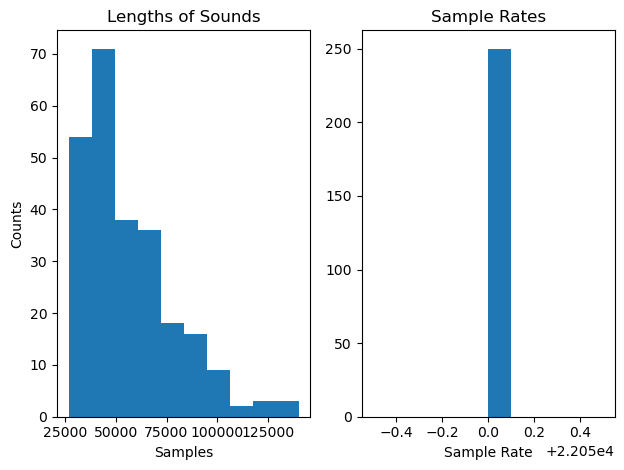

In [9]:
lens = []
srs = []
for f in files:
    data,sr = librosa.load(f)
    lens.append(len(data))
    srs.append(sr)
plt.subplot(1,2,1)
plt.hist(lens)
plt.title('Lengths of Sounds')
plt.xlabel('Samples')
plt.ylabel('Counts')
plt.subplot(1,2,2)
plt.hist(srs)
plt.title('Sample Rates')
plt.xlabel('Sample Rate')
plt.tight_layout()
plt.show()

In [10]:
print(f'Shortest Audio Length: {min(lens)}')
print(f'Sample Rate: {min(srs)}')

Shortest Audio Length: 26781
Sample Rate: 22050


The sample rates for all the sound are the same, however, we can see that the number of samples varies per file changes. To fix this, we can either add trailing zeros onto sounds that don't have enough samples or remove samples from files with more samples. Below, we will remove samples from the files. 

### Remove samples

In [100]:
Data = []
for f in files:
    data,sr = librosa.load(f)
    Data.append(data[0:min(lens)])
Data = np.vstack(Data)

In [12]:
d = Data[10,:]
ipd.Audio(data=d,rate = sr)

## Fast Fourier Transform
We will apply the fast fourier transform (FFT) to the signals to reduce the complexity of the problem by identifying key frequencies that are within each sound. FFT is applied to a given signal $x$ with sample length $N$ as:
$$
    X[k] = \sum^{N-1}_{n=0} = x[n]e^{\frac{-j2\pi kn}{N}}
$$
where $k = 0,...,n-1$. This transformation will be useful for reducing the complexity of the PCA and has an inverse transform that can reconstruct the original time series sound as:
$$
    x[n] = \frac{1}{N}\sum^{N-1}_{k=0} = X[k]e^{\frac{j2\pi kn}{N}}
$$
We will explore this later in the notebook.

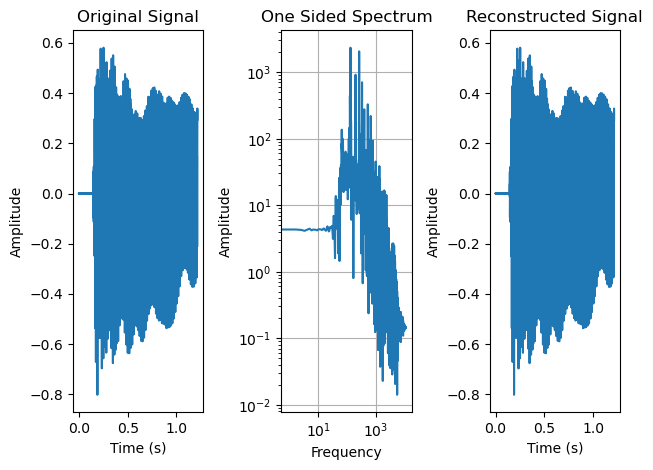

In [26]:
# FFT of example sound
onesided = np.fft.rfft(d)
freq = np.fft.rfftfreq(len(d), d=1./sr)
plt.subplot(1,3,1)
plt.plot(np.arange(0,len(d)/sr,1./sr),d)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.title('Original Signal')
plt.subplot(1,3,2)
plt.loglog(freq,abs(onesided))
plt.ylabel('Amplitude')
plt.xlabel('Frequency')
plt.title('One Sided Spectrum')
plt.grid()
plt.subplot(1,3,3)
plt.plot(np.arange(0,len(d)/sr,1./sr)[:-1],np.fft.irfft(onesided))
plt.title('Reconstructed Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

#### Transform data using FFT

In [28]:
TData = []
for d in Data:
    TData.append(np.fft.rfft(d))
TData = np.vstack(TData)

## Apply PCA
We apply the PCA to the real and imaginary parts of the transformed data. Applying PCA this way, we can can reconstruct sounds later in the notebook. Further description of PCA implementation using numpy linalg is described [here](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html#numpy-linalg-svd).

In [49]:
from numpy.linalg import svd

In [135]:
# calculate SVD
mean = TData.mean(axis=0)
center = TData - mean
U, S, H = svd(center, full_matrices=False) 

In [136]:
# calculate variance explained
variances = S**2 / (TData.shape[0]-1)
explained_variances = variances / np.sum(variances)

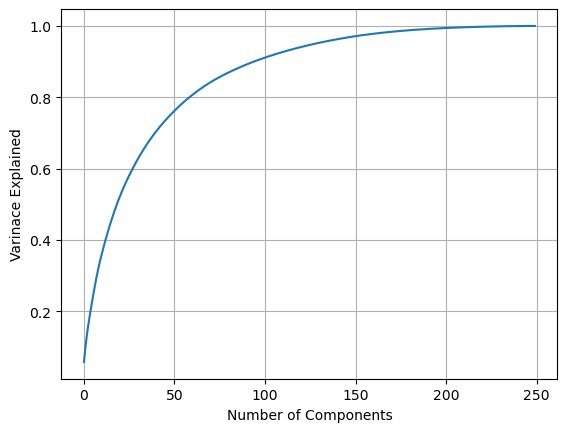

In [137]:
plt.plot(np.cumsum(explained_variances))
plt.ylabel("Varinace Explained")
plt.xlabel("Number of Components")
plt.grid()
plt.show()

We can see that the if we keep the first 95 components, we an explain $90\%$ of the variance. The reconstruction of the signal from these first 95 components is demonstrated below.

In [138]:
numcomp = 95
freqreconData = U[:,:numcomp].dot(np.diag(S[:numcomp]).dot(H[:numcomp,:]))
reconstructedData = np.fft.irfft((freqreconData+mean))

#### Original Sound

In [141]:
ipd.Audio(data=Data[10,:],rate = sr)

#### Reconstructed Sound

In [142]:
ipd.Audio(data=reconstructedData[10,:],rate = sr)

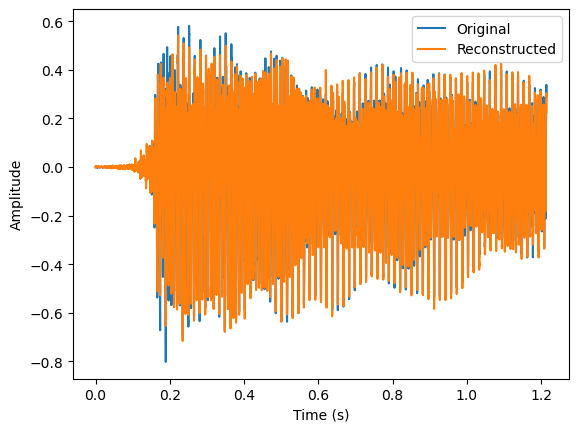

In [145]:
sample = 10
plt.plot(np.arange(0,len(Data[sample,:])/sr,1./sr),Data[sample,:])
plt.plot(np.arange(0,len(reconstructedData[sample,:])/sr,1./sr),reconstructedData[sample,:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(['Original','Reconstructed'])
plt.show()

The above plot shows the original signal and the reconstructed signal as well as audio of the original and reconstructed sounds. From what we hear and see, the sounds are almost similar with some differences due to the removal of some of the principal components. We will now explore what these principal components look like.

## Principal Components
To understand how the SVD is identifying key features in the data to reconstruct sounds, let's look at the eigenvectors (or principal components). The eigenvectors can be thought of as multi-dimensional vectors with magnitude and direction that characterize the data. In another sense, these are the linear projections within the feature space that capture a majority of the explained variance of the data. These projections are orthonormal to each other and are used to reconstruct the sounds with corresponding amplitudes (i.e. $amp = U*Q$ using equations from above). 

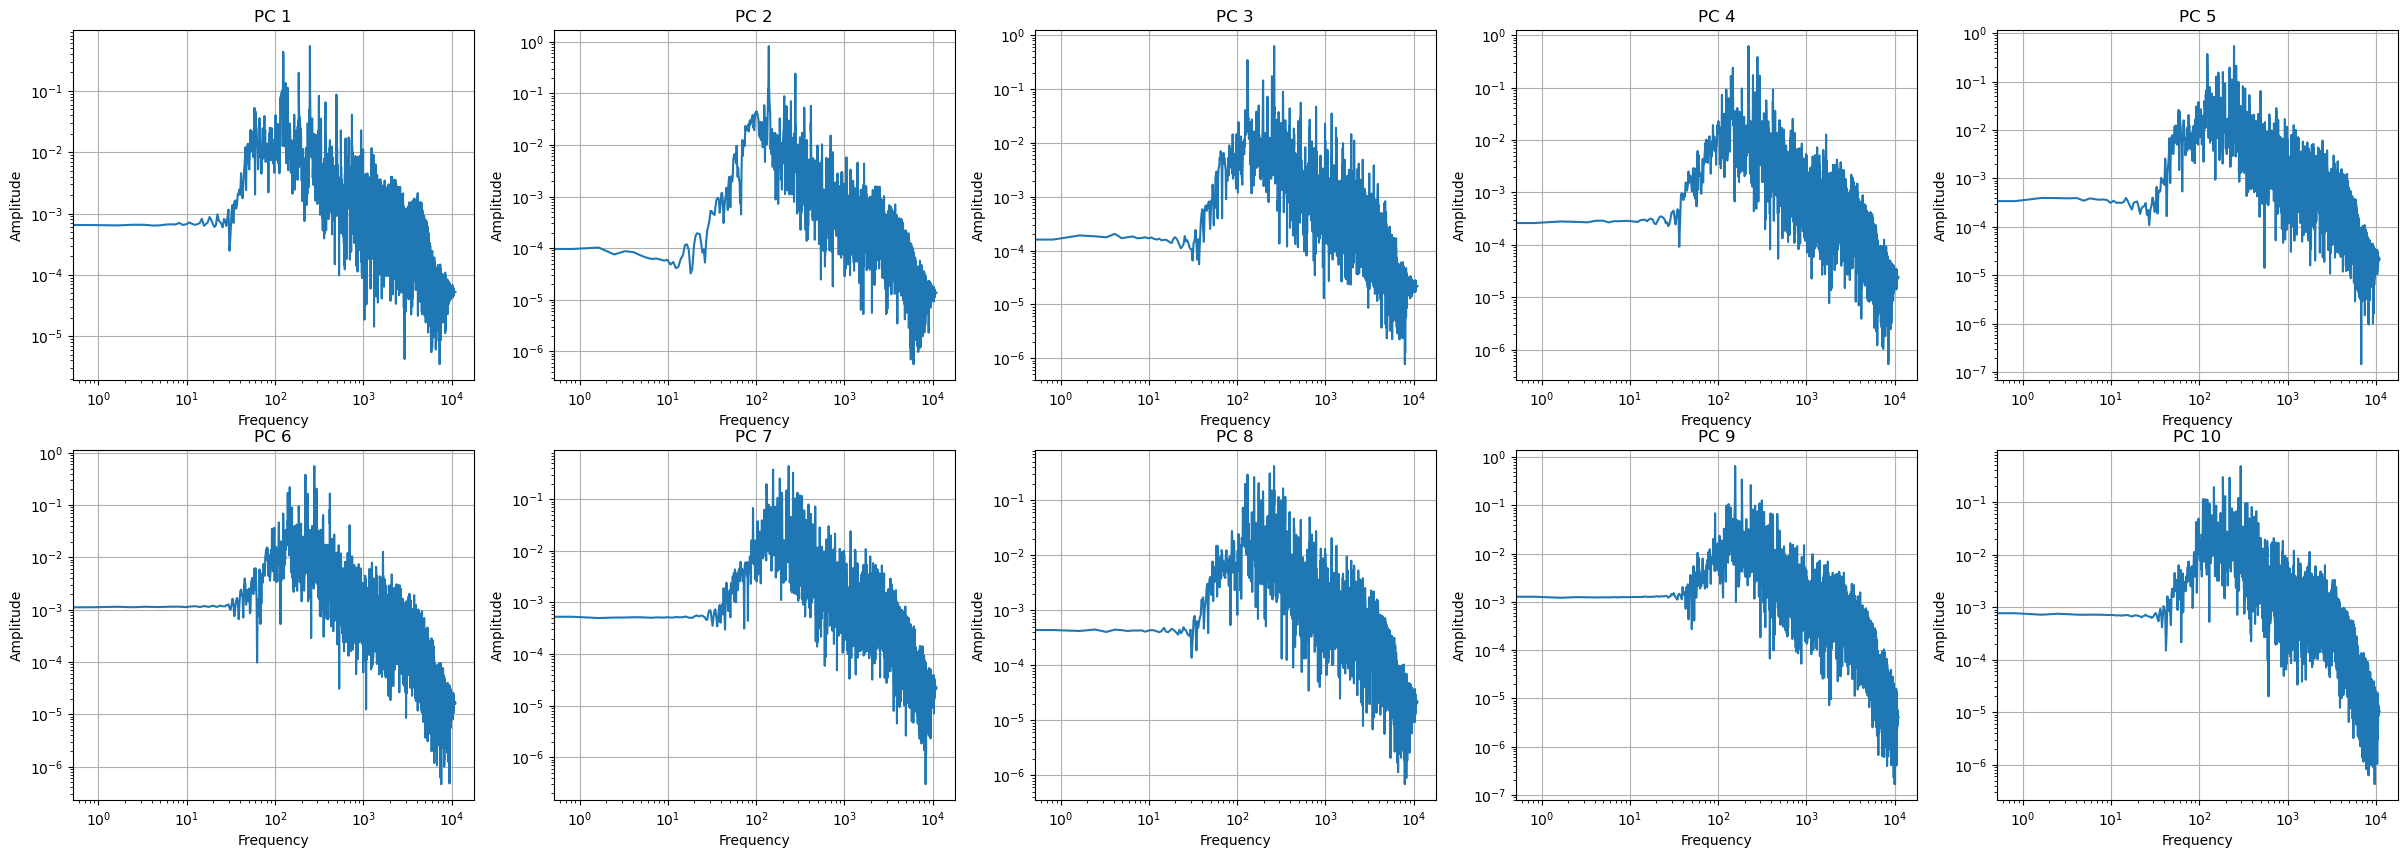

In [157]:
plt.figure(figsize = (30, 10))
freq = np.fft.rfftfreq(len(Data[0,:]), d=1./sr)
ind = 1
for i in H[:10,:]:
    plt.subplot(2,5,ind)
    plt.loglog(freq,abs(i))
    plt.ylabel('Amplitude')
    plt.xlabel('Frequency')
    plt.title(f'PC {ind}')
    plt.grid()
    ind += 1 
plt.show()     

The first few principal components (PC) comprise of the largest amount of variance explain while the subsequent PCs explain less and less variance (see above for the variance explained for the number of components). Through this approach, the PCA has identified a few frequencies that make up a majority of the sounds and adding each PC incroporates different frequencies, liveness, warmth, texture, etc. to the sound.

## Random Guitar Sound
Now that we have the matrices to decompose and reconstruct sounds, let's play with varying the amplitudes to see what sounds we can make. This is done by anlayzing the variation of the amplitudes for each principal component and selecting random values for the amplitudes to reconstruct the sound. Because our amplitudes are complex, we will look at the distribution of the real and imaginary values for each of the principal components.

In [158]:
from scipy.stats import norm

In [160]:
numcomp = 95
amplitudes = U[:,:numcomp].dot(np.diag(S[:numcomp]))

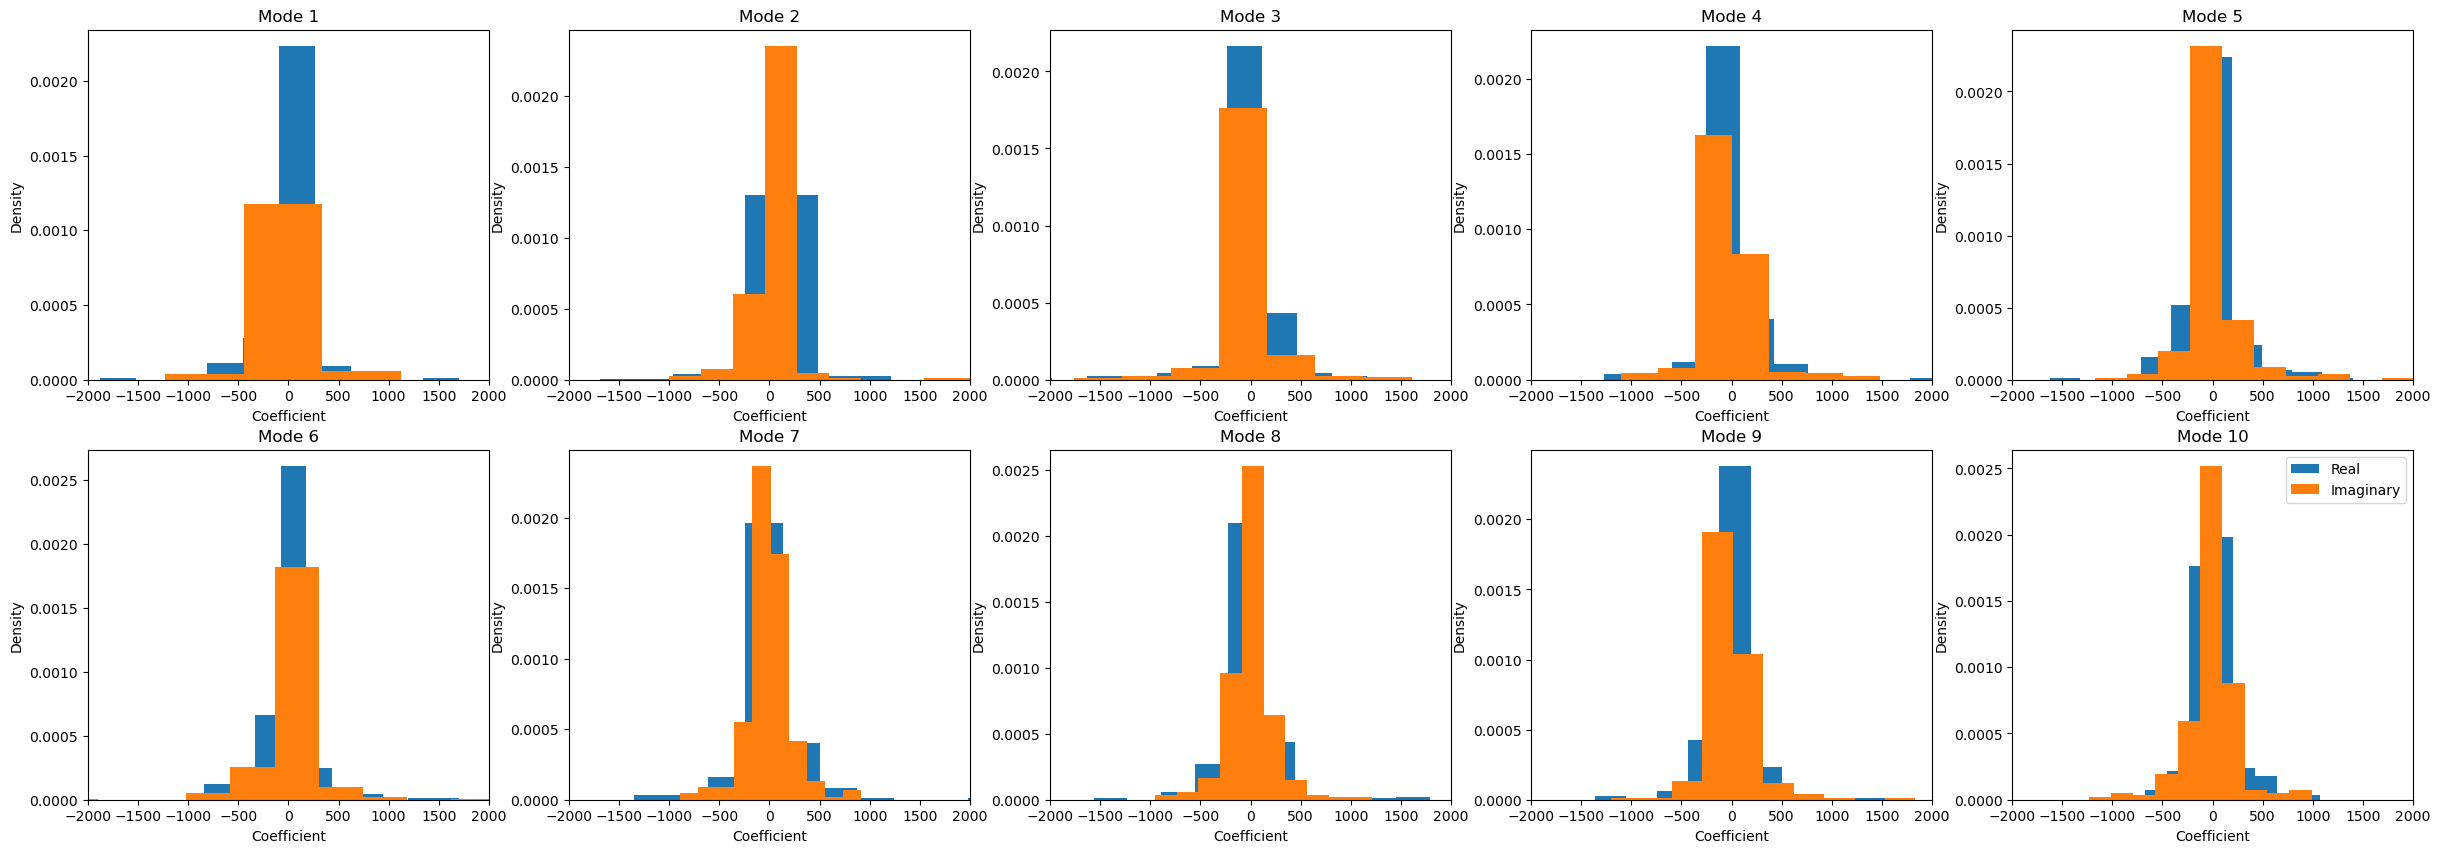

In [172]:
plt.figure(figsize = (30, 10))
ind = 1
for i in amplitudes[:,:10].T:
    plt.subplot(2,5,ind)
    plt.hist(np.real(i),density=True)
    plt.hist(np.imag(i),density=True)
    plt.xlim(-2000,2000)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 1000)
    plt.title(f'Mode {ind}')
    plt.ylabel('Density')
    plt.xlabel('Coefficient')
    ind +=1
plt.legend(['Real','Imaginary'])
plt.show()

Above we can see the distribution of amplitudes for the real and imaginary components. Selecting certain points within these distributions can create a new sound that comprises variations of the frequencies we observed in the principal components. We demonstrate choosing random amplitudes and reconstructing a new sound randomly from this approach.

In [262]:
nComp = 95
amplitudes = U[:,:nComp].dot(np.diag(S[:nComp]))
randomchoice = []
for i in amplitudes[:,:nComp].T:
    mureal, stdreal = norm.fit(np.real(i))
    muimag, stdimag = norm.fit(np.imag(i))
    valuereal = np.random.normal(mureal, stdreal)
    valueimag = np.random.normal(muimag, stdimag)
    randomchoice.append(valuereal+1j*valueimag)
randomchoice = np.array(randomchoice)

In [263]:
# Reconstruct random sound
randomfrequency = randomchoice.dot(H[:nComp,:]) + mean
randomreconstruction = np.fft.irfft(randomfrequency)

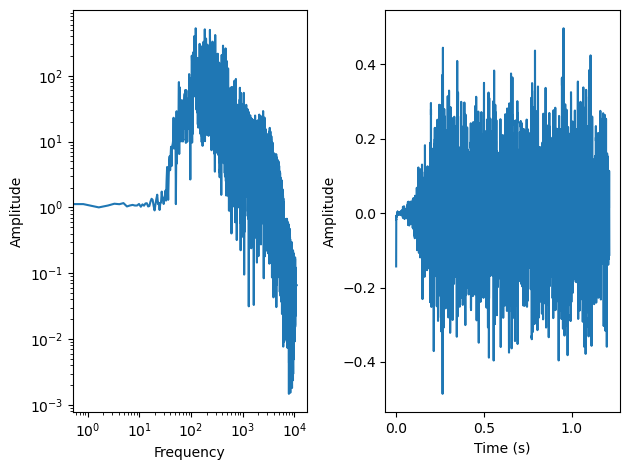

In [264]:
# Visualize random sound
plt.subplot(1,2,1)
plt.loglog(freq,np.abs(randomfrequency))
plt.ylabel('Amplitude')
plt.xlabel('Frequency')
plt.subplot(1,2,2)
plt.plot(np.arange(0,len(randomreconstruction)/sr,1./sr),randomreconstruction)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

In [265]:
ipd.Audio(data=randomreconstruction,rate = sr)

Using the above code, we can create new sounds from the guitar by selecting different variables in feature space and reconstructing the sound. This approach can lead creating new sounds and is useful for understanding the acoustic modes that are present in an instrument or collection of sounds. 

Although we show PCA for reconstructing new sounds, additional works have used PCA to detect signals of interest [here](https://vtechworks.lib.vt.edu/server/api/core/bitstreams/246c0519-bb1a-43ef-bb88-a46abe1104fb/content) or characterizing low frequency ambient noise [here](https://pubs.aip.org/asa/jasa/article/140/4_Supplement/3352/687796/Characterization-of-very-low-frequency-ambient). Through this technique, it is possible to not only represent acoustic sounds through reduced order representations but also apply this techniques for classification or regression in machine learning reducing the complexity of a model. 

# Citations

1) Jolliffe, I. T., & Cadima, J. (2016). Principal component analysis: a review and recent developments. Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 374(2065), 20150202. doi:10.1098/rsta.2015.0202
2) Hoppe E, Roan M. Principal component analysis for emergent acoustic signal detection with supporting simulation results. J Acoust Soc Am. 2011 Oct;130(4):1962-73. doi: 10.1121/1.3628324. PMID: 21973351.
3) Stephen M. Nichols, David L. Bradley; Characterization of very low frequency ambient noise by principal component analysis. J. Acoust. Soc. Am. 1 October 2016; 140 (4_Supplement): 3352. https://doi.org/10.1121/1.4970712
4) Mallary C, Berg CJ, Buck JR, Tandon A. Listening for rain: Principal component analysis and linear discriminant analysis for broadband acoustic rainfall detection. J Acoust Soc Am. 2023 Jul 1;154(1):556-570. doi: 10.1121/10.0020295. PMID: 37504376.
5) Takane, S. (2022). Spatial Principal Component Analysis of Head-Related Transfer Functions and Its Domain Dependency. IntechOpen. doi: 10.5772/intechopen.104449
6) Llanos, F., Nike Gnanateja, G., & Chandrasekaran, B. (2022). Principal component decomposition of acoustic and neural representations of time-varying pitch reveals adaptive efficient coding of speech covariation patterns. Brain and Language, 230, 105122. doi:10.1016/j.bandl.2022.105122
7) Li, J., Dackermann, U., Xu, Y.-L. and Samali, B. (2011), Damage identification in civil engineering structures utilizing PCA-compressed residual frequency response functions and neural network ensembles. Struct. Control Health Monit., 18: 207-226. https://doi.org/10.1002/stc.369